# Zagrava interview

### 1. Import libs and get parameters

First we import libs and get parameters from config and strategy files

strategy.yaml file will be our minimalistic interface in which the user can specify the conditions in which he or she will buy or sell. 

In [179]:
import math
import os
import sys
import time

import ccxt
import matplotlib.pyplot as mplt
import pandas as pd
import yaml
from ccxt.base.decimal_to_precision import ROUND_UP


# get strategy parameters
with open("strategy.yaml", "r") as strategy:
    try:
        strat = yaml.safe_load(strategy)
    except yaml.YAMLError as exc:
        print(exc)

# get config parameters
with open("config.yaml", "r") as config:
    try:
        cfg = yaml.safe_load(config)
    except yaml.YAMLError as exc:
        print(exc)

MSEC = 1000
MINUTE = 60 * MSEC

SYMBOL = cfg['symbol']
WINDOW_SIZE = strat['windowSize']
# add window size to time limit to calculate ewma properly for given time limit
TIME_LIMIT = cfg['timeLimit'] + WINDOW_SIZE
TIME_FRAME = cfg['timeframe']
COMISSION_RATE = cfg['comissionRate']


### 2. Data collection

Now let's get candles from binance. It will be our data collection unit that would gather 1 MINUTE candles in the specified range.

In [180]:
# used some code from ccxt github: https://github.com/ccxt/ccxt/blob/master/examples/py/fetch-ohlcv-on-new-candle.py
exchange = ccxt.binance({
    'enableRateLimit': True,
    'options': {
        'defaultType': 'future',  # futures contracts
    },
})

interval = exchange.parse_timeframe(TIME_FRAME) * 1000

try:
    since = exchange.round_timeframe(
        TIME_FRAME, exchange.milliseconds(), ROUND_UP) - (TIME_LIMIT * interval)
    ohlcv = exchange.fetch_ohlcv(SYMBOL.replace(
        "/", ""), TIME_FRAME, since=since, limit=TIME_LIMIT)
except (ccxt.ExchangeError, ccxt.AuthenticationError, ccxt.ExchangeNotAvailable, ccxt.RequestTimeout) as error:
    print('Got an error', type(error).__name__, error.args)

# leave only updatetime and close price columns and calculate simple moving average
candlesDf = pd.DataFrame(
    ohlcv, columns=['updatetime', 'open', 'high', 'low', 'close', 'volume'])
candlesDf = candlesDf[['updatetime', 'close']]
candlesDf['ma'] = candlesDf['close'].rolling(WINDOW_SIZE).mean()
# cut first window size rows to calculate ewma properly
candlesDf = candlesDf[WINDOW_SIZE:].reset_index(drop=True)

candlesDf


,updatetime,close,ma
0,1667323500000,1573.23,1572.431833
1,1667323560000,1572.22,1572.363667
2,1667323620000,1572.82,1572.336667
3,1667323680000,1572.22,1572.322333
4,1667323740000,1571.54,1572.317500
...,...,...,...
1435,1667409600000,1565.40,1561.182000
1436,1667409660000,1564.41,1561.322167
1437,1667409720000,1564.51,1561.481167
1438,1667409780000,1564.92,1561.641167


Now we have dataframe with close prices and moving everage for specified in config time range

### 3. Data processing

Now let's code our processing unit that would, given the collected data and user strategy, would calculate PnL (realized + unrealized) during each 1min period. And don't forget about comission.

Function get_pnl_df will return two dataframes:<br /> 1) tradesDf wich we will use mostly for troubleshouting and checking that our strategy works as we intended<br /> 2) pndDf with pnl data for each candle

In [181]:
# pnl calculation algorithm was taken from:
# https://www.tradingtechnologies.com/xtrader-help/fix-adapter-reference/pl-calculation-algorithm/understanding-pl-calculations/?cn-reloaded=1
def get_pnl_df(strat: dict, candlesDf: pd.DataFrame) -> pd.DataFrame:
    """Returns two dataframes with pnl and trades based on the strategy parameters and candles dataframe"""
    buyStakeSize = strat['buyStakeSize']
    buyBp = strat['buyBp']
    buyCooldown = strat['buyCooldown']
    buyMaxContracts = strat['buyMaxContracts']
    sellStakeSize = strat['sellStakeSize']
    sellBp = strat['sellBp']
    sellCooldown = strat['sellCooldown']
    sellMinContracts = strat['sellMinContracts']
    lastBuyTradeTime = 0
    lastSellTradeTime = 0
    pnlRealized = 0
    pnlUnrealized = 0
    position = 0
    averageOpenPrice = 0
    pnlUnrealized = 0
    pnlTotal = 0
    comissionTotal = 0

    # create empty dataframes
    tradesDf = pd.DataFrame(columns=['updatetime', 'side', 'price', 'ma',
                            'stakeSize', 'position', 'timeSinceLastTrade'])
    pnlDf = pd.DataFrame(columns=['updatetime', 'close', 'ma', 'pnlRealized',
                         'pnlUnrealized', 'pnlTotal', 'comissionTotal', 'position', 'averageOpenPrice'])

    # for each candle calculate pnl and trades
    for index, row in candlesDf.iterrows():
        # of price is lower then ma, if position will not get grater then we specified and if cooldown is over
        if row['close'] * (1 + buyBp / 10000) < row['ma'] and \
                position + buyStakeSize <= buyMaxContracts and \
                row['updatetime'] - lastBuyTradeTime > buyCooldown * MINUTE:
            # update lastBuyTradeTime and timeSinceLastBuyTrade
            timeSinceLastBuyTrade = (
                row['updatetime'] - lastBuyTradeTime) / MINUTE
            lastBuyTradeTime = row['updatetime']
            # calculate comission
            comissionTotal += buyStakeSize * row['close'] * COMISSION_RATE
            # if position was >= 0 then new buy fills will not affect realized pnl
            # but will affect unrealized pnl and total pnl
            if position >= 0:
                averageOpenPrice = (averageOpenPrice * position + row['close'] * buyStakeSize) / \
                    (position + buyStakeSize)
                position += buyStakeSize
            # if position was < 0 then new buy fills will affect realized pnl, unrealized pnl and total pnl
            elif position < 0:
                pnlRealized += (averageOpenPrice - row['close']) * \
                    min(buyStakeSize, -position)
                position += buyStakeSize
                # if position is still negative averageOpenPrice will not change
                # if position becomes 0 averageOpenPrice will be also 0
                # if position becomes positive averageOpenPrice will be equal to row['close']
                if position == 0:
                    averageOpenPrice = 0
                elif position > 0:
                    averageOpenPrice = row['close']
            tradesDf = tradesDf.append({
                'updatetime': row['updatetime'],
                'side': 'buy',
                'price': row['close'],
                'ma': row['ma'],
                'stakeSize': buyStakeSize,
                'position': position,
                'timeSinceLastTrade': timeSinceLastBuyTrade
            }, ignore_index=True)

        elif row['close'] * (1 - sellBp / 10000) >= row['ma'] and \
                position - sellStakeSize > sellMinContracts and \
                row['updatetime'] - lastSellTradeTime > sellCooldown * MINUTE:
            timeSinceLastSellTrade = (
                row['updatetime'] - lastSellTradeTime) / MINUTE
            lastSellTradeTime = row['updatetime']
            # calculate comission
            comissionTotal += sellStakeSize * row['close'] * COMISSION_RATE
            # if position < 0 then new sell fills will not affect realized pnl
            # but will affect unrealized pnl and total pnl
            if position <= 0:
                averageOpenPrice = (averageOpenPrice * abs(position) + row['close'] * sellStakeSize) / \
                    (abs(position) + sellStakeSize)
                position -= sellStakeSize

            # if position > 0 then new sell fills will affect realized pnl, unrealized pnl and total pnl
            elif position > 0:
                pnlRealized += (row['close'] - averageOpenPrice) * \
                    min(sellStakeSize, position)
                position -= sellStakeSize
                # if position is still positive averageOpenPrice will not change
                # if position becomes 0 averageOpenPrice will be also 0
                # if position becomes negative averageOpenPrice will be equal to row['close']
                if position == 0:
                    averageOpenPrice = 0
                elif position < 0:
                    averageOpenPrice = row['close']
            tradesDf = tradesDf.append({
                'updatetime': row['updatetime'],
                'side': 'sell',
                'price': row['close'],
                'ma': row['ma'],
                'stakeSize': sellStakeSize,
                'position': position,
                'timeSinceLastTrade': timeSinceLastSellTrade
            }, ignore_index=True)
        # update pnlUnrealized and pnlTotal for each candle
        pnlUnrealized = (row['close'] - averageOpenPrice) * position
        pnlTotal = pnlRealized + pnlUnrealized
        # add row to pnlDf
        pnlDf = pnlDf.append({
            'updatetime': row['updatetime'],
            'close': row['close'],
            'ma': row['ma'],
            'pnlRealized': pnlRealized,
            'pnlUnrealized': pnlUnrealized,
            'pnlTotal': pnlTotal,
            'comissionTotal': comissionTotal,
            'position': position,
            'averageOpenPrice': averageOpenPrice
        }, ignore_index=True)
    # add pnlFinal column which shows totalPnl with taking comission into account
    pnlDf['pnlFinal'] = pnlDf['pnlTotal'] - pnlDf['comissionTotal']
    return tradesDf, pnlDf


tradesDf, pnlDf = get_pnl_df(strat, candlesDf)

First let's have a look at tradesDF

In [182]:
tradesDf


,updatetime,side,price,ma,stakeSize,position,timeSinceLastTrade
0,1.667326e+12,sell,1577.90,1572.698167,1,-1,27788759.0
1,1.667326e+12,sell,1579.88,1574.269500,1,-2,11.0
2,1.667327e+12,sell,1581.79,1576.468667,1,-3,21.0
3,1.667329e+12,sell,1584.34,1579.297667,1,-4,25.0
4,1.667332e+12,buy,1576.23,1581.069333,1,-3,27788868.0
5,1.667333e+12,buy,1574.97,1580.136000,1,-2,12.0
6,1.667339e+12,sell,1581.00,1575.564833,1,-3,172.0
7,1.667340e+12,buy,1570.00,1575.662667,1,-2,118.0
8,1.667341e+12,buy,1570.67,1575.475667,1,-1,15.0
9,1.667344e+12,sell,1578.58,1573.491000,1,-2,74.0


We can see that position is always in our interval and timeSinceLastTrade is always grater than cooldown

Now let's have a look at pnlDf

In [183]:
pnlDf


,updatetime,close,ma,pnlRealized,pnlUnrealized,pnlTotal,comissionTotal,position,averageOpenPrice,pnlFinal
0,1.667324e+12,1573.23,1572.431833,0.00,0.00,0.00,0.00000,0.0,0.00,0.00000
1,1.667324e+12,1572.22,1572.363667,0.00,0.00,0.00,0.00000,0.0,0.00,0.00000
2,1.667324e+12,1572.82,1572.336667,0.00,0.00,0.00,0.00000,0.0,0.00,0.00000
3,1.667324e+12,1572.22,1572.322333,0.00,0.00,0.00,0.00000,0.0,0.00,0.00000
4,1.667324e+12,1571.54,1572.317500,0.00,0.00,0.00,0.00000,0.0,0.00,0.00000
...,...,...,...,...,...,...,...,...,...,...
1435,1.667410e+12,1565.40,1561.182000,97.41,0.24,97.65,67.54941,-1.0,1565.64,30.10059
1436,1.667410e+12,1564.41,1561.322167,97.41,1.23,98.64,67.54941,-1.0,1565.64,31.09059
1437,1.667410e+12,1564.51,1561.481167,97.41,1.13,98.54,67.54941,-1.0,1565.64,30.99059
1438,1.667410e+12,1564.92,1561.641167,97.41,0.72,98.13,67.54941,-1.0,1565.64,30.58059


Now let's calculate final pnl via tradesDf and check if we get same numbers.

In [184]:
# initial pnl calculations from https://www.tradingtechnologies.com/xtrader-help/fix-adapter-reference/pl-calculation-algorithm/understanding-pl-calculations/?cn-reloaded=1
tradesDf['quoteQty'] = tradesDf['price'] * tradesDf['stakeSize']
totalBuyQty = tradesDf[tradesDf['side'] == 'buy']['stakeSize'].sum()
if totalBuyQty != 0:
    averageBuyPrice = tradesDf[tradesDf['side']
                               == 'buy']['quoteQty'].sum() / totalBuyQty
else:
    averageBuyPrice = 0
totalSellQty = tradesDf[tradesDf['side'] == 'sell']['stakeSize'].sum()
if totalSellQty != 0:
    averageSellPrice = tradesDf[tradesDf['side']
                                == 'sell']['quoteQty'].sum() / totalSellQty
else:
    averageSellPrice = 0
pnlRealized = (averageSellPrice - averageBuyPrice) * \
    min(totalBuyQty, totalSellQty)

position = totalBuyQty - totalSellQty
if position > 0:
    averageOpenPrice = averageBuyPrice
elif position < 0:
    averageOpenPrice = averageSellPrice
else:
    averageOpenPrice = 0

pnlUnrealized = (candlesDf['close'].iloc[-1] - averageOpenPrice) * position
pnlTotal = pnlRealized + pnlUnrealized
comissionTotal = tradesDf['quoteQty'].sum() * COMISSION_RATE
pnlFinal = pnlTotal - comissionTotal

print('pnlRealized: ', pnlRealized)
print('pnlUnrealized: ', pnlUnrealized)
print('pnlTotal: ', pnlTotal)
print('comissionTotal: ', comissionTotal)
print('pnlFinal: ', pnlFinal)


pnlRealized:  90.0395454545403
pnlUnrealized:  7.720454545454459
pnlTotal:  97.75999999999476
comissionTotal:  67.54941000000001
pnlFinal:  30.210589999994752


We can see that final PnL is the same for both methods so our algorithms should be right. <br /> pnlRealized and pnlUnrealized do not match in different methods. This happens because in second method we calculate average prices for the whole dataframe but in first method we iterate row by row and we don't know future trades and average prices are different.

### 4. Analysis unit

Analysis unit would calculate final PnL, Sharpe ratio, drawdown, and display them to the user alongside with PnL graph

First let's make a function that calculates Sharpes rate

In [185]:
tradingDaysCount = cfg['tradingDaysCount']
riskFreeRate = cfg['riskFreeRate']


def get_sharpe(pnlDf, tradingDaysCount, riskFreeRate):
    # calculate sharpe ratio
    pnlDf['dailyReturn'] = pnlDf['close'].pct_change()
    dailyReturnMean = pnlDf['dailyReturn'].mean()
    dailyReturnStd = pnlDf['dailyReturn'].std()
    sharpeRatio = (dailyReturnMean - riskFreeRate /
                   tradingDaysCount) / dailyReturnStd
    # calculate annualized sharpe ratio
    annualizedSharpeRatio = sharpeRatio * math.sqrt(tradingDaysCount)
    return sharpeRatio, annualizedSharpeRatio


sharpeRatio, annualizedSharpeRatio = get_sharpe(
    pnlDf, tradingDaysCount, riskFreeRate)

annualizedSharpeRatio


-0.07563248369912536

Now calculate maximum drawdown in percents

In [186]:
# function to calculate maximum drawdown in percent
def get_drawdown(pnlDf):
    if pnlDf.pnlFinal.iloc[-1] == 0:
        return 0
    pnlDf['drawdown'] = pnlDf['pnlFinal'].cummax() - pnlDf['pnlFinal']
    maxDrawdown = pnlDf['drawdown'].max()
    maxDrawdownPercent = maxDrawdown / pnlDf['pnlFinal'].cummax().max() * 100
    return maxDrawdownPercent


maxDrawdown = get_drawdown(pnlDf)
maxDrawdown

264.91762322936927

Finally we plot a graph

Text(0.8, 0.95, 'Sharpe Ratio: -0.0\nMaximum Drawdown: 265 %')

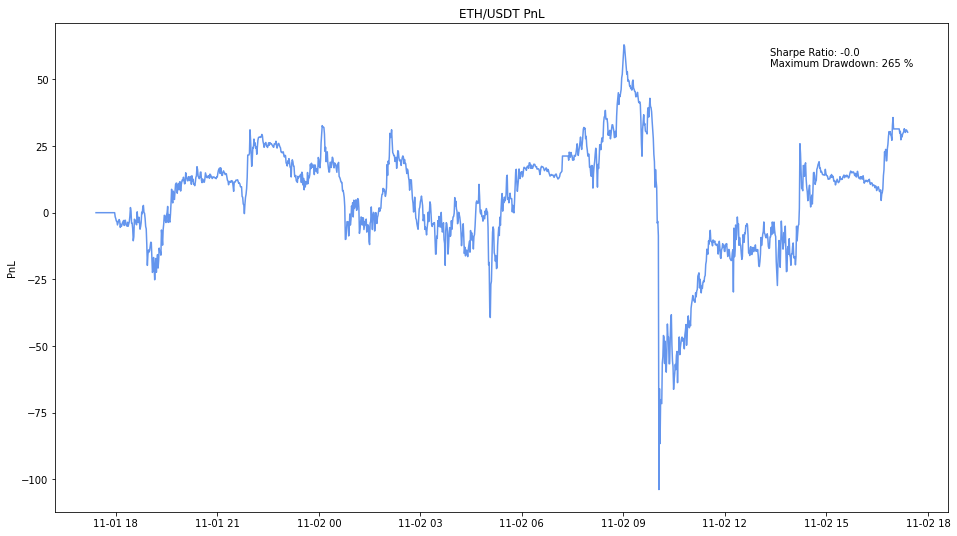

In [187]:
pnlDf['updatetime'] = pd.to_datetime(pnlDf['updatetime'], unit='ms')
pnlDf = pnlDf.set_index('updatetime')

fig, ax = mplt.subplots()
fig.set_size_inches(16, 9, forward=True)
ax.set_title(str(SYMBOL) + ' PnL')
ax.plot(pnlDf.pnlFinal, color='cornflowerblue')
ax.set_ylabel('PnL')
ax.set_title(SYMBOL+" PnL")
# добавляем текст справа сверху
box_text = ''
box_text += 'Sharpe Ratio: ' + str(round(sharpeRatio, 2)) + '\n'
box_text += 'Maximum Drawdown: ' + str(round(maxDrawdown)) + ' %'
ax.text(0.8, 0.95, box_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top')


Let's plot one more graph with price, moving average and trades for better user experience.

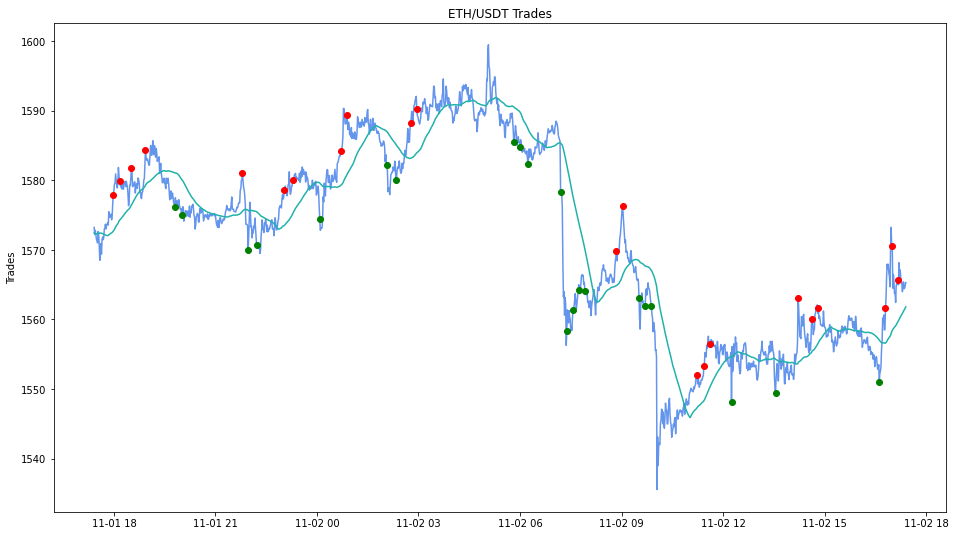

In [188]:
tradesDf['updatetime'] = pd.to_datetime(tradesDf['updatetime'], unit='ms')
tradesDf = tradesDf.set_index('updatetime')
buyTradesDf = tradesDf[tradesDf.side == 'buy']
sellTradesDf = tradesDf[tradesDf.side == 'sell']

fig, ax = mplt.subplots()
fig.set_size_inches(16, 9, forward=True)
ax.set_title(str(SYMBOL) + ' Trades')
ax.plot(pnlDf.close, color='cornflowerblue')
ax.plot(pnlDf.ma, color='lightseagreen')
ax.set_ylabel('Trades')
ax.set_title(SYMBOL+" Trades")
ax.plot(buyTradesDf.price, 'o', color='green')
ax.plot(sellTradesDf.price, 'o', color='red')


image.png

On this graph we can see how our strategy performed.

Now we will create service based on this notebook.